In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import catboost as cb
from tqdm.notebook import tqdm

# from xgboost import plot_importance, plot_tree

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import random

plt.style.use('default')

In [2]:
!nvidia-smi

Sat Jun  1 12:06:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Functions

In [3]:
def ts_array_create(dirname, dir_list, time_seq):
    
    columns = ['RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
               'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2']
    
    def reamin_HO_time(y_train):
        def f(L):    
            for i, e in enumerate(L):
                if e: return i+1
            return 0

        out = []
        for a2 in y_train:
            a1_out = []
            for a1 in a2:
                a1_out.append(a1.any())
      
            out.append(f(a1_out))
        return out
    
    def HO(y_train):
        out = []
        for a2 in y_train:
            if sum(a2.reshape(-1)) == 0: ho = 0
            elif sum(a2.reshape(-1)) > 0: ho = 1
            out.append(ho)
        return out

    split_time = []
    for i, f in enumerate(tqdm(dir_list)):
    
        f = os.path.join(dirname, f)
        df = pd.read_csv(f)

        
        # preprocess data with ffill method
        del df['Timestamp'], df['lat'], df['long'], df['gpsspeed']
        # df[columns] = df[columns].replace(0, np.nan)
        # df[columns] = df[columns].fillna(method='ffill')
        # df.dropna(inplace=True)
        
        df.replace(np.nan,0,inplace=True); df.replace('-',0,inplace=True)
        
        X = df[features]
        Y = df[target]

        Xt_list = []
        Yt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)
    
        for j in range(time_seq,time_seq+predict_t):
            Y_t = Y.shift(periods=-(j))
            Yt_list.append(Y_t)

        # YY = Y.shift(periods=-(0))

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq+predict_t-1),:,:]
        Y_ts = np.array(Yt_list); Y_ts = np.transpose(Y_ts, (1,0,2)); Y_ts = Y_ts[:-(time_seq+predict_t-1),:,:]
        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = Y_ts
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,Y_ts), axis=0)

    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]
    
    return X_final, np.array(HO(Y_final)), np.array(reamin_HO_time(Y_final)), split_time # forecast HO


In [4]:
def days_in_file(file, dates):
    
    for date in dates:
        if date in file: return True 
    return False

def train_valid_split(L, valid_size=0.2):
    
    length = len(L)
    v_num = int(length*valid_size)
    v_files = random.sample(L, v_num)
    t_files = list(set(L) - set(v_files))
    
    return t_files, v_files

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seed set as {seed}")

# Load Data

In [5]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 20
predict_t = 2
valid_ratio = 0.2
task = 'classification'

In [6]:
# Setup seed
set_seed(seed)

# Get GPU
device_count = torch.cuda.device_count()
num_of_gpus = device_count

for i in range(device_count):
    print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
    gpu_id = i

# Save best model to 
save_path = "/kaggle/working"

# Define DataSet
dirname = "/kaggle/input/111111"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ] # Take out cell phone data

# train_dates = ['03-26', '04-01']
# test_dates = ['04-10']
    
# train_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, train_dates) )]
# test_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, test_dates) )]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Add cell phone data.

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

# target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]


Random seed set as 55688
GPU 0: Tesla P100-PCIE-16GB
Loading training data...


  0%|          | 0/12 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/3 [00:00<?, ?it/s]

# 特別任務處理

In [7]:
# Time sequence length and prediction time length
time_seq = 20
predict_t = 10
valid_ratio = 0.2

# Define DataSet
dirname = "/kaggle/input/222222"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not '08-21' in f) ) ] # Take out cell phone data

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Add cell phone data.

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]


Loading training data...


  0%|          | 0/5 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
L = []
record_file = '/kaggle/working/2023-09-09-record.csv'

f = open(record_file, 'w')
f.write(','.join([ 'num','roc_auc', 'aucpr', 'p', 'r', 'f1']) + '\n')

for i, l in enumerate(train_dir_list):
    
    L.append(l)
    
    features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
    
    num_of_features = len(features)
    
    target = ['LTE_HO', 'MN_HO'] # For eNB HO.
    # target = ['eNB_to_ENDC'] # Setup gNB
    # target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
    # target = ['RLF'] # For RLF
    # target = ['SCG_RLF'] # For scg failure
    # target = ['dl-loss'] # For DL loss
    # target = ['ul-loss'] # For UL loss
    
    
    # Data
    print('Loading training data...')
    X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, L, time_seq)
    X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
    cond = y_train2 > 0
    X_train_fore = X_train_2d[cond]
    y_train2_fore = y_train2[cond]


    print('Loading testing data...')
    X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
    X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
    cond = y_test2 > 0
    X_test_fore = X_test_2d[cond]
    y_test2_fore = y_test2[cond]
    
    model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed) 
    
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    # 選擇最佳迭代次數
    best_iteration = model.best_iteration_

    # 使用最佳迭代次數重新訓練模型
    model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                                colsample_bylevel=0.8, scale_pos_weight=1,
                                loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    
    preds = model.predict_proba(X_test_2d)[:, 1]
    
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    
    p = precision_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds]) 
    r = recall_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    f1 = f1_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    
    print(i, roc_auc, aucpr, p, r, f1)
    write_list = [ i+1, roc_auc, aucpr, p, r, f1]
    write_list = [str(s) for s in write_list]
    f.write(','.join(write_list) + '\n')
    

f.close()


Loading training data...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

0 0.5110258868648131 0.3989897355485942 0.4603174603174603 0.29591836734693877 0.36024844720496896
Loading training data...


  0%|          | 0/2 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

1 0.5551636762087385 0.42681694711740104 0.4945054945054945 0.45918367346938777 0.4761904761904762
Loading training data...


  0%|          | 0/3 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

2 0.44452814682920144 0.3640870212074464 0.38235294117647056 0.3979591836734694 0.38999999999999996
Loading training data...


  0%|          | 0/4 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

3 0.4606560745103411 0.3821804839713496 0.41935483870967744 0.3979591836734694 0.4083769633507854
Loading training data...


  0%|          | 0/5 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

4 0.5122585947130529 0.3855184187973844 0.4225352112676056 0.30612244897959184 0.35502958579881655


In [9]:
f.close()

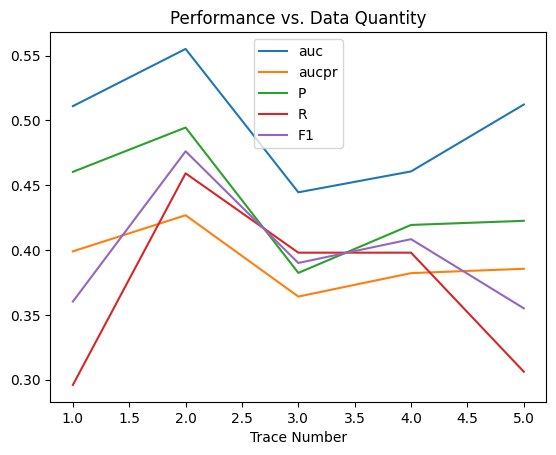

In [10]:
file = '/kaggle/working/2023-09-09-record.csv'
df = pd.read_csv(file)

x = df['num']
y1 = df['roc_auc']
y2 = df['aucpr']
y3 = df['p']
y4 = df['r']
y5 = df['f1']

plt.plot(x, y1, label = 'auc')
plt.plot(x, y2, label = 'aucpr')
plt.plot(x, y3, label = 'P')
plt.plot(x, y4, label = 'R')
plt.plot(x, y5, label = 'F1')

plt.title('Performance vs. Data Quantity')
plt.xlabel('Trace Number')

plt.legend()
plt.show()

In [11]:
# L = []
# record_file = '../info/2023-09-09-record2.csv'

# f = open(record_file, 'w')
# f.write(','.join([ 'num', 'rmse', 'mae']) + '\n')

# for i, l in enumerate(train_dir_list):
    
#     L.append(l)
    
#     features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
    
#     num_of_features = len(features)
    
#     target = ['LTE_HO', 'MN_HO'] # For eNB HO.
#     # target = ['eNB_to_ENDC'] # Setup gNB
#     # target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
#     # target = ['RLF'] # For RLF
#     # target = ['SCG_RLF'] # For scg failure
#     # target = ['dl-loss'] # For DL loss
#     # target = ['ul-loss'] # For UL loss
    
    
#     # Data
#     print('Loading training data...')
#     X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, L, time_seq)
#     X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
#     cond = y_train2 > 0
#     X_train_fore = X_train_2d[cond]
#     y_train2_fore = y_train2[cond]


#     print('Loading testing data...')
#     X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
#     X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
#     cond = y_test2 > 0
#     X_test_fore = X_test_2d[cond]
#     y_test2_fore = y_test2[cond]
    
    
#     model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
#                               loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 
#     model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)
#     best_iteration = model.best_iteration_
#     model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
#                                 loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 
#     model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)

    
#     preds = model.predict(X_test_fore)    
    
#     rmse = mean_squared_error(y_test2_fore, preds, squared=False)
#     mae = mean_absolute_error(y_test2_fore, preds)
    
#     print(rmse, mae)
    
#     write_list = [ i+1, rmse, mae]
#     write_list = [str(s) for s in write_list]
#     f.write(','.join(write_list) + '\n')
    

# f.close()


In [12]:
f.close()

# **Forecast**

In [16]:
# Setup seed
set_seed(seed)

# Get GPU
device_count = torch.cuda.device_count()
num_of_gpus = device_count

for i in range(device_count):
    print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
    gpu_id = i

# Save best model to 
save_path = "/kaggle/working"

# Define DataSet
dirname = "/kaggle/input/222222"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ] # Take out cell phone data

# train_dates = ['03-26', '04-01']
# test_dates = ['04-10']
    
# train_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, train_dates) )]
# test_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, test_dates) )]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Add cell phone data.

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

# target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]

Random seed set as 55688
GPU 0: Tesla P100-PCIE-16GB
Loading training data...


  0%|          | 0/5 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Time sequence length and prediction time length
time_seq = 20
predict_t = 10
valid_ratio = 0.2

# Define DataSet
dirname = "/kaggle/input/222222"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not '08-21' in f) ) ] # Take out cell phone data

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Add cell phone data.

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]

Loading training data...


  0%|          | 0/5 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
L = []
record_file = '/kaggle/working/2023-09-09-record.csv'

f = open(record_file, 'w')
f.write(','.join([ 'num','roc_auc', 'aucpr', 'p', 'r', 'f1']) + '\n')

for i, l in enumerate(train_dir_list):
    
    L.append(l)
    
    features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
    
    num_of_features = len(features)
    
    target = ['LTE_HO', 'MN_HO'] # For eNB HO.
    # target = ['eNB_to_ENDC'] # Setup gNB
    # target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
    # target = ['RLF'] # For RLF
    # target = ['SCG_RLF'] # For scg failure
    # target = ['dl-loss'] # For DL loss
    # target = ['ul-loss'] # For UL loss
    
    
    # Data
    print('Loading training data...')
    X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, L, time_seq)
    X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
    cond = y_train2 > 0
    X_train_fore = X_train_2d[cond]
    y_train2_fore = y_train2[cond]


    print('Loading testing data...')
    X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
    X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
    cond = y_test2 > 0
    X_test_fore = X_test_2d[cond]
    y_test2_fore = y_test2[cond]
    
    model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed) 
    
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    # 選擇最佳迭代次數
    best_iteration = model.best_iteration_

    # 使用最佳迭代次數重新訓練模型
    model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                                colsample_bylevel=0.8, scale_pos_weight=1,
                                loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    
    preds = model.predict_proba(X_test_2d)[:, 1]
    
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    
    p = precision_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds]) 
    r = recall_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    f1 = f1_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    
    print(i, roc_auc, aucpr, p, r, f1)
    write_list = [ i+1, roc_auc, aucpr, p, r, f1]
    write_list = [str(s) for s in write_list]
    f.write(','.join(write_list) + '\n')
    

f.close()

Loading training data...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

0 0.5110258868648131 0.3989897355485942 0.4603174603174603 0.29591836734693877 0.36024844720496896
Loading training data...


  0%|          | 0/2 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

1 0.5551636762087385 0.42681694711740104 0.4945054945054945 0.45918367346938777 0.4761904761904762
Loading training data...


  0%|          | 0/3 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

2 0.44452814682920144 0.3640870212074464 0.38235294117647056 0.3979591836734694 0.38999999999999996
Loading training data...


  0%|          | 0/4 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

3 0.4606560745103411 0.3821804839713496 0.41935483870967744 0.3979591836734694 0.4083769633507854
Loading training data...


  0%|          | 0/5 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/1 [00:00<?, ?it/s]

4 0.5122585947130529 0.3855184187973844 0.4225352112676056 0.30612244897959184 0.35502958579881655


# Train

In [ ]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[8], split_time_test[9]]

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

# y_test
# preds

for i in range(sample_value):
    true = [y_test1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    # prediciton = [preds[i] for i in range(samples[i][0], samples[i][1])]
    prediciton = [1 if preds[i] > 0.5 else 0 for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

In [ ]:
A = [test_dir_list[split_time_test.index(s)] for s in samples]
A

In [ ]:
# Check whethet it do good on training data
sample_value = 2
samples = random.sample(split_time_train, sample_value)
preds_train = model.predict(X_train_2d)

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    true = [y_train1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds_train[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

# grid search

In [ ]:
import itertools

iterations =  [100, 200, 300]
learning_rates = [0.1, 0.01, 0.001]
depths = [4, 6, 8, 10]
l2_leaf_regs = [0.1, 1, 10]
border_counts =  [5, 10, 20]
colsample_bylevels = [0.5, 0.8, 1]
scale_pos_weights = [1, 2, 5]

In [ ]:
f_out = 'lte_ho_cls_cb.csv'
f_out = open(f_out, 'w')
cols_out = ['iteration','learning_rate','depth', 'l2_leaf_reg', 'border_count','colsample_bylevel','scale_pos_weight','auc','aucpr', 'p', 'r', 'f1','acc']
f_out.write(','.join(cols_out)+'\n')

for itera, lr, dep, l2_leaf, bc, cbl, spw in itertools.product(iterations, learning_rates, depths, l2_leaf_regs, border_counts, colsample_bylevels, scale_pos_weights):
    
    print(itera, lr, dep, l2_leaf, bc, cbl, spw)
    model = cb.CatBoostClassifier(iterations=itera,  learning_rate = lr, depth = dep, l2_leaf_reg = l2_leaf, 
                                  border_count = bc, colsample_bylevel= cbl,scale_pos_weight = spw, 
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
    
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    
    preds = model.predict_proba(X_test_2d)[:, 1]
    
    # AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    aucpr = auc(recall, precision)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    threshold = 0.5

    p = precision_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    r = recall_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    f1 = f1_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    acc = accuracy_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    
    cols_out = [itera, lr, dep, l2_leaf, bc, cbl, spw, roc_auc, aucpr, p, r, f1, acc]
    cols_out = [str(n) for n in cols_out]
    f_out.write(','.join(cols_out)+'\n')
    
f_out.close()

In [ ]:
import pandas as pd
df = pd.read_csv('lte_ho_cls_cb.csv')
max_value = df['aucpr'].max()
max_index = df['aucpr'].idxmax()
print(df.iloc[max_index])
max_value = df['auc'].max()
max_index = df['auc'].idxmax()
print(df.iloc[max_index])


# Forecast

In [ ]:
model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
                              loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 

In [ ]:
model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)
best_iteration = model.best_iteration_
model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
                              loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 
model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)

In [ ]:
preds = model.predict(X_test_fore)

In [ ]:
rmse = mean_squared_error(y_test2_fore, preds, squared=False)
mae = mean_absolute_error(y_test2_fore, preds)
rmse, mae

In [ ]:
model.save_model('../model/nr_HO_fst_cb')

# Load Model

In [ ]:
model = cb.CatBoostClassifier()      # parameters not required.
model.load_model('../model/nr_HO_cls_cb')

In [ ]:
preds = model.predict_proba(X_test_2d)[:, 1]

In [ ]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

# PR and AUCPR
precision, recall, thresholds = precision_recall_curve(y_test1, preds)
aucpr = auc(recall, precision)

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test1, preds)
roc_auc = auc(fpr, tpr)

# Manually count
for threshold in ths:
    TP, FP, TN, FN = 0,0,0,0
    anses = np.where(preds<threshold, 0, 1)
    for ans, y in zip(anses, y_test1):
        if ans == y:
            if ans == 1: TP += 1
            elif ans == 0: TN +=1
        elif ans != y:
            if ans == 1: FP += 1
            elif ans == 0: FN +=1
    acc=(TP+TN)/(TP+TN+FP+FN)*100
    try:
        p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
        f1 = round(2*(p*r)/(p+r), 2)
    except:
        p, r, f1 = 'DNF', 'DNF', 'DNF'
    s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
    print(s)

# 初始化閥值列表和 F1 Score 列表
thresholds = []
f1_scores = []

# 循環遍歷閥值，計算 F1 Score
for threshold in range(5, 101, 5):
    threshold /= 100
    y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
    f1_scores.append(f1_score(y_test1, y_pred_threshold))
    thresholds.append(threshold)

print(f'roc_auc: {roc_auc}')
print(f'aucpr: {aucpr}')

In [ ]:
model = cb.CatBoostRegressor()     # parameters not required.
model.load_model('../model/nr_HO_fst_cb')

In [ ]:
preds = model.predict(X_test_fore)

In [ ]:
rmse = mean_squared_error(y_test2_fore, preds, squared=False)
mae = mean_absolute_error(y_test2_fore, preds)
rmse, mae

In [ ]:
preds